# Predicting Chub Density based on river environment

github: https://github.com/bendavidhayes/ML_Final_Project.git

# Project Topic
This Notebook analyzes how the environment impacts fish life, specifically a fish called chub.

**Goal:** The objective of the analysis is to develop a model to accurately predict the amount of fish in a river section, based on environmental factors. 

# Data Description
The Data used in this analysis was provided by the University of Natural Resources and Life Sciences in Vienna, Austria. 

It was collected in a variety of rivers in Austria. For each observation a section of a river was contained using nets. All fish in the containment were caught, weighed and then released. The target in this analysis is the biomass of all Chub caught in a section, measured in kg/ha.

**target:** 
- Chub_BIO: Chub Biomass (kg/ha)

**features:**
- Fischregion
- CL1_Artificial surfaces: Proportion of Area surrounding the catchment area that is artificial, e.g. Buildings, streets.
- SSI: Standard Sinuousity Index (higher values reflect more curves in the river)
- BW_MORPH: Riverbank width morphology index
- PHB_SAPRO: phytobenthic condition
- MZB_SAPRO: saprobic condition
- TROPH_ZUST: trophic condition
- ZUST_SCHAD = ZUST_SCHADST_EU_2015: pollutant grading according to EU standard
- ZUST_BIO_7 = ZUST_BIOLOGIE_STOFFE_2015: grading of biological condition
- LAUFENTWICKLUNG: development of river run
- SUBSTRATZUSAMMENSETZUNG: composition of river substrate
- FIA: Fish Index Austria
- Chub_corridor_m: length of river system, that is accessible to fish
- 5J_AMP_50_REL_MAXNAT: hydrological variable                  
- 5J_MAFR_CNT: hydrological variable

# Import Libraries & Data 

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy as sp
import scipy.stats as stats
import seaborn as sns

In [2]:
#read csv
csv_file_path = 'C:/Users/benda/cyprinid_2023.csv'
biomass = pd.read_csv(csv_file_path, delimiter=';', decimal=',')

# labels of features and targets to include in analysis
columns_to_keep = ["Chub_BIO",
                   "Fischregion",
                   "CL1_Artificial surfaces",
                   "SSI",
                   "BW_MORPH",
                   "PHB_SAPRO",
                   "MZB_SAPRO",
                   "TROPH_ZUST",
                   "ZUST_SCHAD = ZUST_SCHADST_EU_2015",
                   "ZUST_BIO_7 = ZUST_BIOLOGIE_STOFFE_2015",
                   "LAUFENTWICKLUNG",
                   "SUBSTRATZUSAMMENSETZUNG",
                   "FIA",
                   "Chub_corridor_m",
                   "5J_AMP_50_REL_MAXNAT",                   
                   "5J_MAFR_CNT",
                  ]

biomass = biomass[columns_to_keep] # select features for analysis
# transform FIA into float64
biomass['FIA'] = biomass['FIA'].str.replace(',', '.', regex=True).astype(float)

# collaps variables in feature "Fischregion"
to_replace = ["Hyporhithral groß", "Hyporhithral klein", 
              "Epipotamal groß", "Epipotamal mittel", "Epipotamal klein",
              "Epipotamal mittel 1", "Epipotamal mittel 2"]
replacement = ["Hyporhithral", "Hyporhithral", 
               "Epipomatal", "Epipomatal", "Epipomatal",
               "Epipomatal", "Epipomatal"]

biomass["Fischregion"].replace(to_replace, replacement, inplace=True)

# EDA & Data Cleaning

Since the EDA informs the Data Cleaning Steps needed I decided to combine the two. This helps avoids showing the same visuals for different purposes twice. 

In [3]:
biomass.info() # show basic info about data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Chub_BIO                                115 non-null    float64
 1   Fischregion                             115 non-null    object 
 2   CL1_Artificial surfaces                 115 non-null    float64
 3   SSI                                     115 non-null    float64
 4   BW_MORPH                                53 non-null     float64
 5   PHB_SAPRO                               115 non-null    object 
 6   MZB_SAPRO                               115 non-null    float64
 7   TROPH_ZUST                              115 non-null    object 
 8   ZUST_SCHAD = ZUST_SCHADST_EU_2015       115 non-null    int64  
 9   ZUST_BIO_7 = ZUST_BIOLOGIE_STOFFE_2015  115 non-null    int64  
 10  LAUFENTWICKLUNG                         91 non-null     float6

The data set has 115 observations and 16 features (including the target). There are 10 quantitative variables, 3 ordinal, and 3 qualitative. Four features have missing values. 

### Summary Statistics

In [4]:
pd.set_option('display.max_columns', 150) # increase max columns shown in output

biomass.describe() # summary statistics of quantitative variables

,Chub_BIO,CL1_Artificial surfaces,SSI,BW_MORPH,MZB_SAPRO,ZUST_SCHAD = ZUST_SCHADST_EU_2015,ZUST_BIO_7 = ZUST_BIOLOGIE_STOFFE_2015,LAUFENTWICKLUNG,SUBSTRATZUSAMMENSETZUNG,FIA,Chub_corridor_m,5J_AMP_50_REL_MAXNAT,5J_MAFR_CNT
count,115.000000,115.000000,115.000000,53.000000,115.000000,115.000000,115.000000,91.000000,87.000000,115.000000,114.000000,115.000000,115.000000
mean,36.168235,0.062406,1.077643,0.142628,1.782609,1.017391,2.286957,1.846154,1.356322,3.312087,16454.471047,0.357959,1538.713043
std,56.564671,0.015785,0.113820,0.135535,0.146306,0.186501,0.722632,0.681878,0.570129,0.827941,29514.763080,0.108584,3020.306499
min,0.000000,0.033827,1.000000,0.019885,1.250000,1.000000,1.000000,1.000000,1.000000,1.780000,82.622809,0.224370,4.000000
25%,0.000000,0.051312,1.008264,0.064863,1.750000,1.000000,2.000000,1.000000,1.000000,2.750000,1942.316884,0.272438,119.000000
50%,7.768000,0.063618,1.041361,0.099541,1.750000,1.000000,2.000000,2.000000,1.000000,3.260000,4149.509374,0.336563,213.000000
75%,45.880000,0.071134,1.108768,0.168475,1.750000,1.000000,2.500000,2.000000,2.000000,3.950000,12136.898517,0.406962,1465.500000
max,326.084000,0.087296,1.913400,0.879331,2.000000,3.000000,7.000000,3.000000,3.000000,5.000000,123485.137800,0.851794,19640.000000


In [5]:
biomass.head()

,Chub_BIO,Fischregion,CL1_Artificial surfaces,SSI,BW_MORPH,PHB_SAPRO,MZB_SAPRO,TROPH_ZUST,ZUST_SCHAD = ZUST_SCHADST_EU_2015,ZUST_BIO_7 = ZUST_BIOLOGIE_STOFFE_2015,LAUFENTWICKLUNG,SUBSTRATZUSAMMENSETZUNG,FIA,Chub_corridor_m,5J_AMP_50_REL_MAXNAT,5J_MAFR_CNT
0,0.00,Hyporhithral,0.070794,1.007143,0.062240,I-II B,1.50,mt,1,2,2.0,2.0,5.0,9429.460433,0.279878,6128
1,0.00,Hyporhithral,0.051312,1.041361,0.168475,I-II B,1.75,me1,1,2,NaN,NaN,5.0,30268.862880,0.238242,1623
2,0.00,Hyporhithral,0.040292,1.121244,0.080595,I-II B,1.50,om,1,2,NaN,NaN,4.0,79230.114260,0.266632,4711
3,0.00,Hyporhithral,0.040292,1.042523,0.063849,I-II B,1.75,om,1,2,NaN,NaN,5.0,79230.114260,0.271759,4003
4,0.01,Hyporhithral,0.040292,1.129526,0.096156,I-II B,1.75,om,1,2,NaN,NaN,5.0,79230.114260,0.271759,4004


### Correlation

In [6]:
biomass.corr()

C:\Users\benda\AppData\Local\Temp\ipykernel_2312\2084939813.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  biomass.corr()


,Chub_BIO,CL1_Artificial surfaces,SSI,BW_MORPH,MZB_SAPRO,ZUST_SCHAD = ZUST_SCHADST_EU_2015,ZUST_BIO_7 = ZUST_BIOLOGIE_STOFFE_2015,LAUFENTWICKLUNG,SUBSTRATZUSAMMENSETZUNG,FIA,Chub_corridor_m,5J_AMP_50_REL_MAXNAT,5J_MAFR_CNT
Chub_BIO,1.000000,0.261430,0.085997,0.165504,0.143203,0.131053,0.182150,0.088531,0.048613,-0.386005,-0.220738,0.448390,-0.261384
CL1_Artificial surfaces,0.261430,1.000000,-0.005526,0.122175,0.259991,0.024699,0.166062,0.095971,-0.189610,-0.251162,-0.387683,0.421268,-0.351328
SSI,0.085997,-0.005526,1.000000,0.308774,0.086686,-0.063399,0.112231,-0.164914,-0.141465,-0.195856,-0.136852,0.270942,-0.079804
BW_MORPH,0.165504,0.122175,0.308774,1.000000,0.379584,NaN,0.200858,0.067082,-0.039393,-0.089231,-0.260197,0.277298,-0.270984
MZB_SAPRO,0.143203,0.259991,0.086686,0.379584,1.000000,0.139773,0.221852,0.145032,-0.140083,-0.251307,-0.238651,0.225730,-0.299024
ZUST_SCHAD = ZUST_SCHADST_EU_2015,0.131053,0.024699,-0.063399,NaN,0.139773,1.000000,0.092820,0.179358,-0.067785,-0.072952,-0.033998,-0.063383,-0.047799
ZUST_BIO_7 = ZUST_BIOLOGIE_STOFFE_2015,0.182150,0.166062,0.112231,0.200858,0.221852,0.092820,1.000000,0.165331,0.040299,-0.209790,-0.117888,0.236834,-0.156935
LAUFENTWICKLUNG,0.088531,0.095971,-0.164914,0.067082,0.145032,0.179358,0.165331,1.000000,0.475179,0.349685,-0.127221,0.154252,-0.175154
SUBSTRATZUSAMMENSETZUNG,0.048613,-0.189610,-0.141465,-0.039393,-0.140083,-0.067785,0.040299,0.475179,1.000000,0.337124,-0.085878,-0.028876,0.042397
FIA,-0.386005,-0.251162,-0.195856,-0.089231,-0.251307,-0.072952,-0.209790,0.349685,0.337124,1.000000,0.376283,-0.310837,0.146017


C:\Users\benda\AppData\Local\Temp\ipykernel_2312\729294388.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(biomass.corr(), vmin=-1, vmax=1,cmap='BrBG', annot=True)


Text(0.5, 1.0, 'Correlation Heatmap')

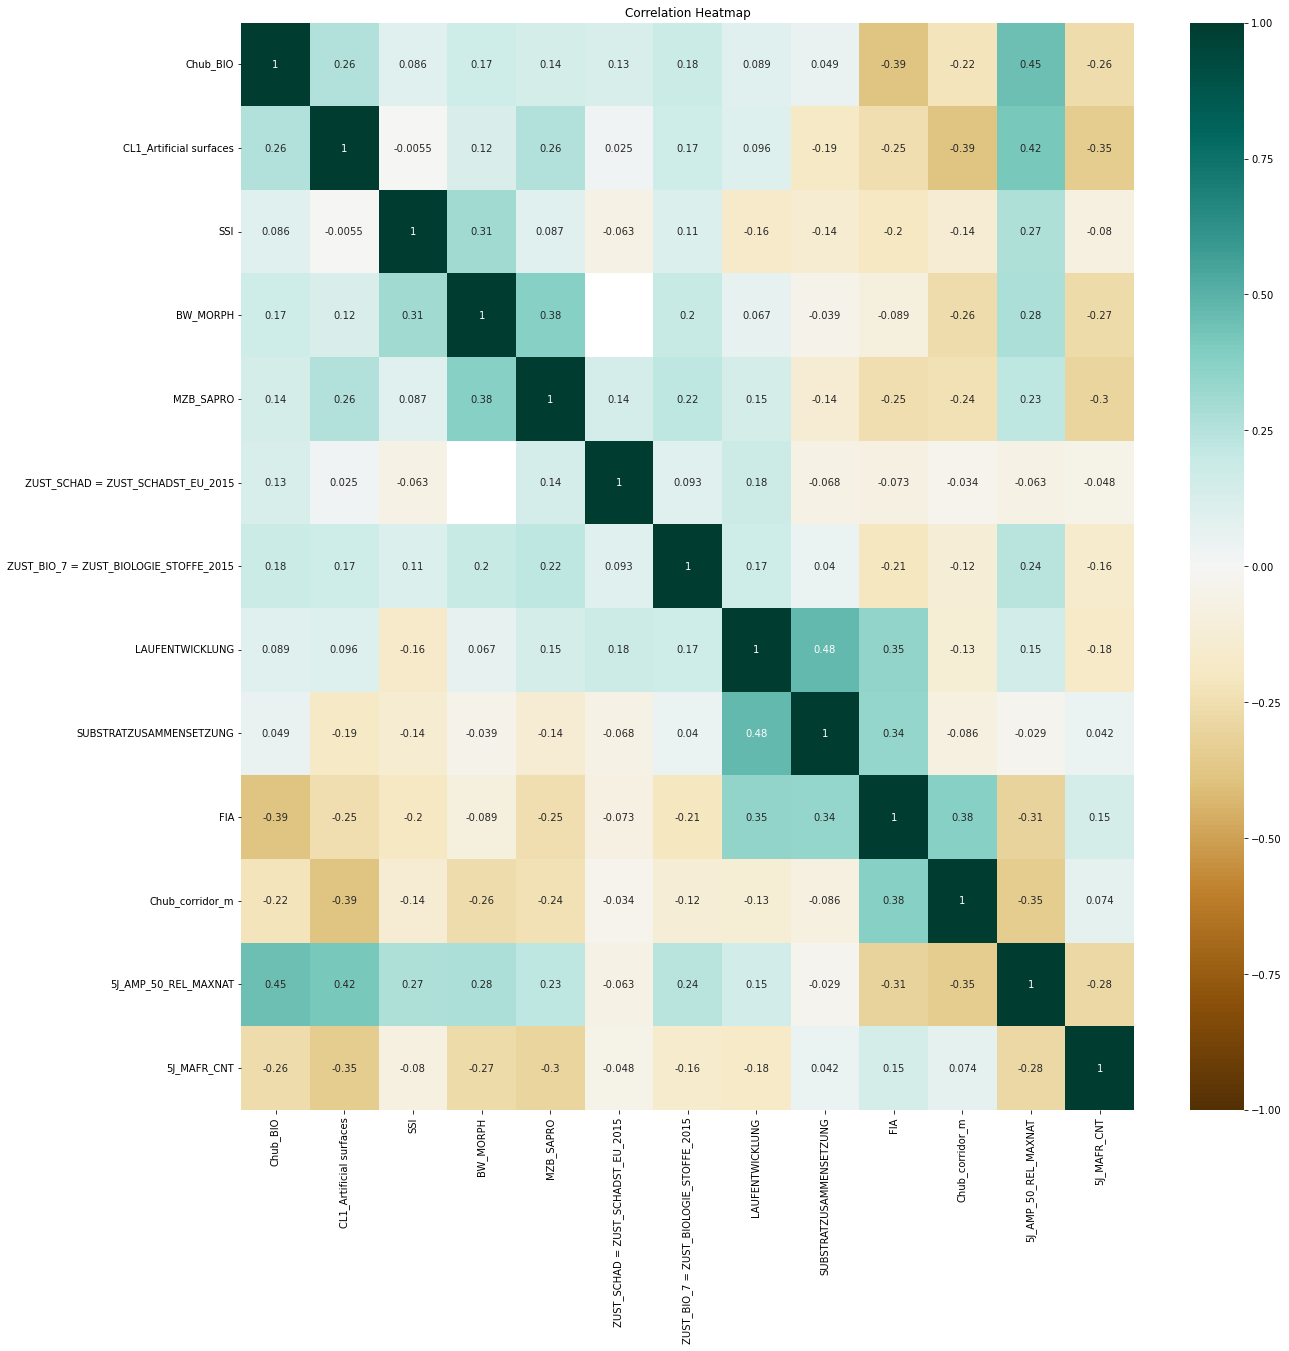

In [7]:
# plot the correlation using a heatmap
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(biomass.corr(), vmin=-1, vmax=1,cmap='BrBG', annot=True)
heatmap.set_title("Correlation Heatmap")

**Important Features:** Based on the correlation matrix, it looks like the most important features in predicting: 'Chub_BIO' are 
- '5J_AMP_50_REL_MAXNAT'(corr=0.45), 
- 'FIA'(corr=-0.39), 
- 'CL1_Artificial surfaces' (corr=0.26), and 
- 5J_MAFR_CNT (corr=-0.26)


**Collinearity:** The two features "SUBSTRATZUSAMMENSETZUNG" and "LAUFENTWICKLUNG" are very collinear, with a correlation between them of 0.48. Since "LAUFENTWICKLUNG" also has a stronger correlation with the target, I will keep it, and remove the other feature.

In [8]:
bm1 = biomass.drop("LAUFENTWICKLUNG", axis=1) # remove feature from dataframe

### Distribution of Data

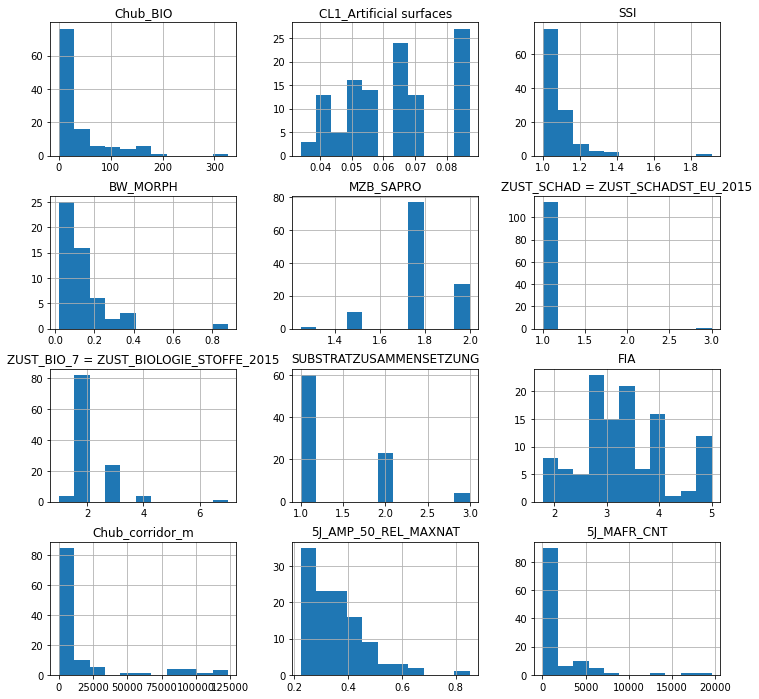

In [9]:
# plot numerical variables as histogram
bm1.hist(bins=11, figsize=(12, 12));

It's clear that "ZUST_SCHAD = ZUST_SCHADST_EU_2015" can be removed. Since almost all observations are identical, it will add no value to the model. 

In [10]:
bm2 = bm1.drop("ZUST_SCHAD = ZUST_SCHADST_EU_2015", axis=1)

**Note on logarithmic transformation:** A lot of the features have a strong right skew. They might need to be logarithmically transformed, if more advanced linear methods are applied. However since not all models need normally distributed data, I will wait until we know which type of model to develop to decide whether to transform them.

### Vizualize categorical data

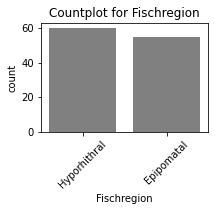

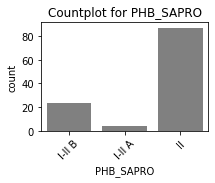

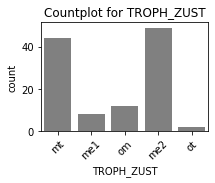

In [11]:
# bar plot for visualizing categorical data
# select categorical features
categorical_columns = bm2.select_dtypes(include=['object']).columns

for column in categorical_columns:
    plt.figure(figsize=(3, 2))  # Set the size of the plot
    sns.countplot(x=column, data=bm2, color='gray')  # Create a countplot
    plt.title(f'Countplot for {column}')  # Set the title of the plot
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

### Impute missing values

In [12]:
bm2.isna().sum() # check for missing values

Chub_BIO                                   0
Fischregion                                0
CL1_Artificial surfaces                    0
SSI                                        0
BW_MORPH                                  62
PHB_SAPRO                                  0
MZB_SAPRO                                  0
TROPH_ZUST                                 0
ZUST_BIO_7 = ZUST_BIOLOGIE_STOFFE_2015     0
SUBSTRATZUSAMMENSETZUNG                   28
FIA                                        0
Chub_corridor_m                            1
5J_AMP_50_REL_MAXNAT                       0
5J_MAFR_CNT                                0
dtype: int64

**Features with missing values:**

- "Chub_corridor_m" is missing a single value. We'll just remove that row.

The other two features with missing values can be removed because: 
- "BW_MORPH" has nearly 50% missing
- "SUBSTRATZUSAMMENSETZUNG has 25% missing values and little correlation to the target. Since it is also collinear to another feature, some of the information will be retained in the model anyways. But before removing it, we'll check if there is any non-linear correlation to the target.

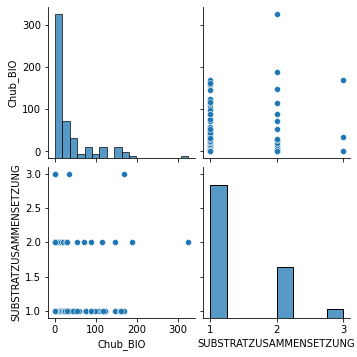

In [13]:
sns.pairplot(bm2.loc[:,["Chub_BIO", "SUBSTRATZUSAMMENSETZUNG"]])

Since the pairplot also shows little correlation with the target, I will remove the feature "SUBSTRATZUSAMMENSETZUNG".

In [14]:
# remove the two features
bm3 = bm2.drop(["BW_MORPH", "SUBSTRATZUSAMMENSETZUNG"], axis=1)
# remove the row, where "Chub_corridor_m" has a missing value
bm3 = bm3.loc[biomass.Chub_corridor_m.notna(),:]

### Recode Categorical Variables
to improve linear regression the categorical variables will be encoded as binary dummy variables.

In [15]:
# create list of categorical columns
categorical_data = bm3.select_dtypes(include='object')
categorical_labels = list(categorical_data.columns)
print(categorical_labels)

['Fischregion', 'PHB_SAPRO', 'TROPH_ZUST']


In [16]:
# Encode categorical features as dummy variables and remove original variables
bm4 = pd.get_dummies(bm3)

In [17]:
# look at new features
bm4.head()

,Chub_BIO,CL1_Artificial surfaces,SSI,MZB_SAPRO,ZUST_BIO_7 = ZUST_BIOLOGIE_STOFFE_2015,FIA,Chub_corridor_m,5J_AMP_50_REL_MAXNAT,5J_MAFR_CNT,Fischregion_Epipomatal,Fischregion_Hyporhithral,PHB_SAPRO_I-II A,PHB_SAPRO_I-II B,PHB_SAPRO_II,TROPH_ZUST_me1,TROPH_ZUST_me2,TROPH_ZUST_mt,TROPH_ZUST_om,TROPH_ZUST_ot
0,0.00,0.070794,1.007143,1.50,2,5.0,9429.460433,0.279878,6128,0,1,0,1,0,0,0,1,0,0
1,0.00,0.051312,1.041361,1.75,2,5.0,30268.862880,0.238242,1623,0,1,0,1,0,1,0,0,0,0
2,0.00,0.040292,1.121244,1.50,2,4.0,79230.114260,0.266632,4711,0,1,0,1,0,0,0,0,1,0
3,0.00,0.040292,1.042523,1.75,2,5.0,79230.114260,0.271759,4003,0,1,0,1,0,0,0,0,1,0
4,0.01,0.040292,1.129526,1.75,2,5.0,79230.114260,0.271759,4004,0,1,0,1,0,0,0,0,1,0


### Summary of EDA
Few features seem to be normally distributed; this means that transformations could improve linear models, and even become necessary enable use of more complex linear models like Ridge Regression or Lasso. 

3 features were removed: 
- 2 because of large amounts of missing data
- 1 because nearly all values were identical

**Analysis Strategy:** Since the aim is to develop the most accurate prediction, I will compare the estimated test error of multiple base models using cross validation on the training set. This will give an idea on which model to choose for finetuning: I will finetune model with the best score (Mean Squared Error). After training this final model, I will calculate the real test error on the test set to evaluate performance on new data.

# Model training


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (cross_val_score,
                                     GridSearchCV,
                                    train_test_split)
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import (RandomForestRegressor as RFR,
                             AdaBoostRegressor as ADA,
                             GradientBoostingRegressor as GBR)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Normalizer

### Split Data

In [19]:
bm5 = bm4.copy() 

y = bm5["Chub_BIO"]
X = bm5.drop("Chub_BIO", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The training set has 91 samples and 18 attributes.  
The test set has 23 samples and 18 attributes.

### Multilinear Regression

In [20]:
# estimate the test error of the multilinear model
lm = LinearRegression()
-cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=10).sum()/10

2813.5259668306426

### Decision Tree

In [21]:
# estimate the test error of a basic Decision Tree Model
dt = DTR(random_state=42)
-cross_val_score(dt, X_train, y_train, scoring='neg_mean_squared_error', cv=10).sum()/10

3318.7657664888893

### Random Forest


In [22]:
# estimate the test error of a Random Forest Model
rf = RFR(random_state=42)
-cross_val_score(rf, X_train, y_train, scoring='neg_mean_squared_error', cv=10).sum()/10

2460.1840555830495

### Gradient Boosting

In [23]:
# estimate the test error of a Gradient Boosting Model
gb = GBR(random_state=42)
-cross_val_score(gb, X_train, y_train, scoring='neg_mean_squared_error', cv=10).sum()/10

2685.8869596836685

### AdaBoost

In [24]:
# estimate the test error using an AdaBoost Model
ada = ADA(random_state=42)
-cross_val_score(ada, X_train, y_train, scoring='neg_mean_squared_error', cv=10).sum()/10

2940.48751384636

### Finetuning Best Model
Since the Random Forest Model gives the best estimated test error, I will fine tune this model using Grid Search. Also since we are using Random Forest there is no need to transform the exponentially distributed features and target. There is also no need to normalize the data.

In [25]:
rf = RFR()

parameters = {'n_estimators': [200, 300, 500],
              'max_features': ['sqrt', 'log2', None],
              'max_depth' : [4,5,6,7,8]
}

clf = GridSearchCV(rf, parameters, scoring='neg_mean_squared_error', cv=5)

In [26]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [200, 300, 500]},
             scoring='neg_mean_squared_error')

### Results and Analysis

In [27]:
# best parameters for Random Forest Model
clf.best_estimator_

RandomForestRegressor(max_depth=5, max_features='log2', n_estimators=300)

In [28]:
print("Mean Squared Error of best Random Forest Estimator is: ", -clf.best_score_) 

Mean Squared Error of best Random Forest Estimator is:  2267.762333010481


In [29]:
# calculate test error
y_pred = clf.predict(X_test)

In [30]:
print("Mean Squared Error of tuned Random Forest on test data: ", mean_squared_error(y_test, y_pred))

Mean Squared Error of tuned Random Forest on test data:  2317.8045507310608


In [31]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Mean Squared Error of basic Random Forest on test data: ", mean_squared_error(y_test, y_pred))

Mean Squared Error of basic Random Forest on test data:  3482.92131482647


**Feature Importance**
Random Forests are not intuitive for Inferrence of feature importance. I will normalize the data and run a linear model to find the most important features. I decided to normalize rather than standardize the data, since the distribution of most columns is not normal.

In [32]:
# Normalize data
bm5_norm = Normalizer().fit_transform(bm5)
X_norm = bm5_norm[:,1:]
y_norm = bm5_norm[:,0]

In [33]:
# feature importance
lm = LinearRegression()
lm.fit(X_norm, y_norm)
coef_labels = pd.Series(lm.coef_, X_train.columns)
coef_labels.sort_values()

TROPH_ZUST_om                            -156.231931
SSI                                      -123.166781
FIA                                       -78.237445
ZUST_BIO_7 = ZUST_BIOLOGIE_STOFFE_2015    -31.393109
PHB_SAPRO_II                              -26.870764
Chub_corridor_m                            -0.113990
5J_MAFR_CNT                                -0.078099
PHB_SAPRO_I-II B                           60.832188
TROPH_ZUST_me2                             61.251178
TROPH_ZUST_mt                              75.415045
TROPH_ZUST_ot                              84.232325
Fischregion_Hyporhithral                   96.061458
Fischregion_Epipomatal                    103.723130
TROPH_ZUST_me1                            135.117972
5J_AMP_50_REL_MAXNAT                      150.501993
PHB_SAPRO_I-II A                          165.823164
MZB_SAPRO                                 178.528449
CL1_Artificial surfaces                   181.111743
dtype: float64

This shows which features have the highest impact on the model: the features that have the largest absolute coefficients: 
- CL1_Artificial surfaces
- MZB_SAPRO
- PHB_SAPRO_I-II A
- TROPH_ZUST_om
- 5J_AMP_50_REL_MAXNAT

Only two of these features showed significance when looking at the correlation heat map. This as well as the scatterplots above, suggest that the relationships between the other features and the target are more complex (interactions, polynomials). Using polynomial regression could improve upon the feature analysis.

### Discussion
As expected more complex models performed better than linear regression. Hyperparameter tuning gave us the final best parameters for RandomForest:
- max_depth=4 
- max_features='sqrt'
- n_estimators=200  

This model improved upon training error compared to the basic Random Forest Model by nearly 10%. Although the test error of the final model is 15% higher than the training error, the test error is lower than training errors of all other models.

However this difference between training and test error suggests the model is overfitting. There are 3 ways to improve this: 
1. Feature Selection
2. Test more hyperparameters on RF
3. use a simpler model: linear regression. As expected Linear base model might have performed poorly due to shape of data distributions. Transforming, and normalizing data would improve performance. Also using polynomial regression could improve performance.